# Transfer Learning with TensorFlow pt3: Scalling up

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food 101 paper with 10% of the training (leveraging the power of deep learning). 

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat 50.76% accuracy across 101 classes

## Creating helper functions

In previous notebooks, we've created a series of helper functions todo different tasks, let's download them

In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [20]:
# Import series of helper functions for this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it 

The data we're downloading comes from the original Food101 dataset but has been preprocessed 

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-06-14 14:51:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.186.176, 142.250.185.80, 216.58.212.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.186.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1,5G) [application/zip]
Saving to: '101_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  332K 79m34s
    50K .......... .......... .......... .......... ..........  0%  519K 65m17s
   100K .......... .......... .......... .......... ..........  0%  423K 64m23s
   150K .......... .......... .......... .......... ..........  0% 5,09M 49m33s
   200K .......... .......... .......... .......... ..........  0%  908K 45m28s
   250K .......... .......... .......... .......... ..........  0% 2,16M 39m52s
   300K .......... .......... .......... .......... ......

In [3]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [5]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extreact for 5 full passes (5 epochs on the train dataset and validat on 15% of the test data, to save epoch time)

In [6]:
# Create checkpoints callback
checkpoint_path = "101_food_classes_10_percent_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=False,
                                                         save_freq="epoch")

In [7]:
# Create data augmentation layer to incorporate into model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2 but EfficientNet's have rescaling built-in
], name="data_augmentation")

In [8]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # put base model in inference mode, only want to use it for feature extraction
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [10]:
# Fit the model (validate on 15% of the data)
history_10_percent_data_aug = model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=int(0.15 * len(test_data)),
                                        callbacks=[create_tensorboard_callback( dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230614-152400
Epoch 1/5
237/237 [==============================] - 126s 497ms/step - loss: 3.3732 - accuracy: 0.2689 - val_loss: 2.4531 - val_accuracy: 0.4727
Epoch 2/5
237/237 [==============================] - 114s 483ms/step - loss: 2.1997 - accuracy: 0.5001 - val_loss: 1.9990 - val_accuracy: 0.5246
Epoch 3/5
237/237 [==============================] - 115s 485ms/step - loss: 1.8213 - accuracy: 0.5681 - val_loss: 1.8627 - val_accuracy: 0.5318
Epoch 4/5
237/237 [==============================] - 114s 480ms/step - loss: 1.6103 - accuracy: 0.6087 - val_loss: 1.8000 - val_accuracy: 0.5408
Epoch 5/5
237/237 [==============================] - 115s 483ms/step - loss: 1.4539 - accuracy: 0.6459 - val_loss: 1.7682 - val_accuracy: 0.5413


In [12]:
# Evaluate on the full test dataset
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 83s 105ms/step - loss: 1.5789 - accuracy: 0.5851


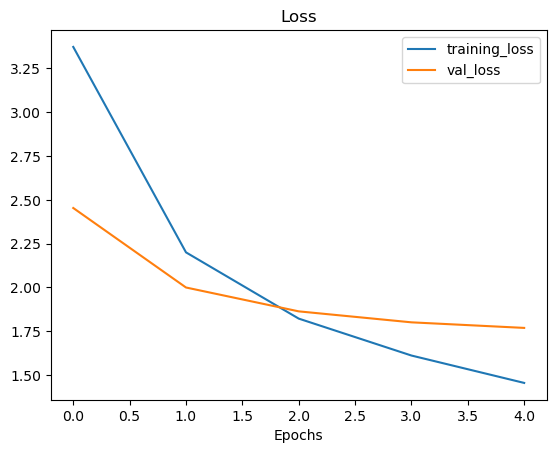

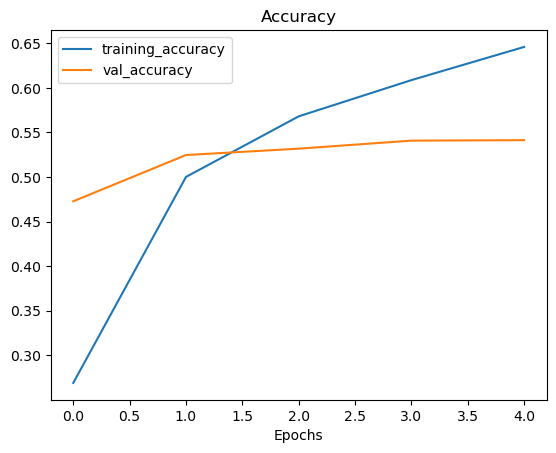

In [13]:
# Plot the loss curves
plot_loss_curves(history_10_percent_data_aug)

### Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [15]:
#Recompile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [17]:
# Fine-tune for another 5 epochs
fine_tune_epochs = 10
history_10_percent_data_aug_fine_tune = model.fit(train_data_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    steps_per_epoch=len(train_data_10_percent),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    initial_epoch=history_10_percent_data_aug.epoch[-1],
                                                    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                            experiment_name="10_percent_data_aug_fine_tune_last_5")])
                                                                                            

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug_fine_tune_last_5/20230614-154808
Epoch 5/10
237/237 [==============================] - 116s 459ms/step - loss: 1.2146 - accuracy: 0.6841 - val_loss: 1.7620 - val_accuracy: 0.5384
Epoch 6/10
237/237 [==============================] - 107s 449ms/step - loss: 1.1065 - accuracy: 0.7063 - val_loss: 1.7183 - val_accuracy: 0.5469
Epoch 7/10
237/237 [==============================] - 107s 450ms/step - loss: 1.0083 - accuracy: 0.7316 - val_loss: 1.7108 - val_accuracy: 0.5479
Epoch 8/10
237/237 [==============================] - 107s 450ms/step - loss: 0.9491 - accuracy: 0.7443 - val_loss: 1.7438 - val_accuracy: 0.5442
Epoch 9/10
237/237 [==============================] - 107s 452ms/step - loss: 0.8915 - accuracy: 0.7579 - val_loss: 1.7412 - val_accuracy: 0.5429
Epoch 10/10
237/237 [==============================] - 106s 448ms/step - loss: 0.8414 - accuracy: 0.7732 - val_loss: 1.7725 - val_accuracy: 0.5387


In [18]:
# Evaluate the model
results_fine_tune_10_percent = model.evaluate(test_data)

790/790 [==============================] - 80s 101ms/step - loss: 1.4977 - accuracy: 0.6023


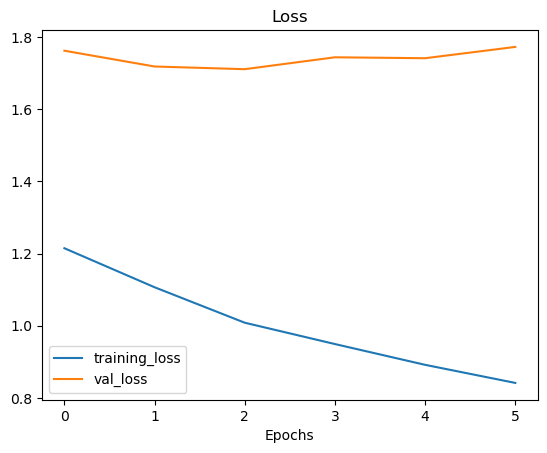

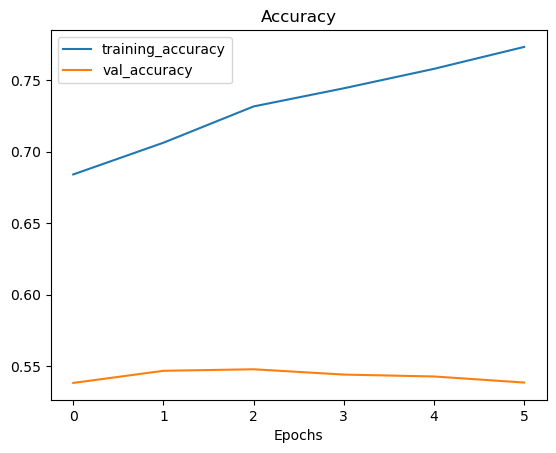

In [19]:
# Plot the loss curves
plot_loss_curves(history_10_percent_data_aug_fine_tune)

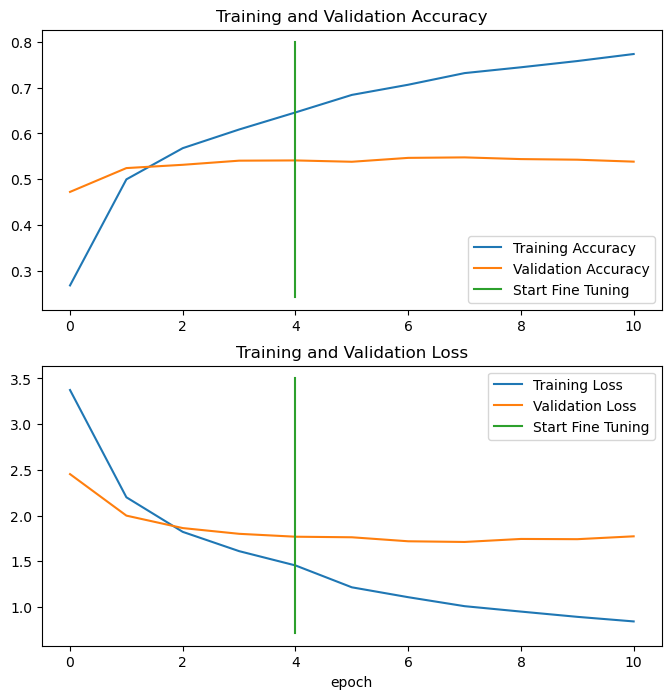

In [21]:
# Compare historys
compare_historys(history_10_percent_data_aug, history_10_percent_data_aug_fine_tune, 5)